## Part II. Decicion Trees

### Importing Packages

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from pylab import rcParams
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Function for Model Evaluation

In [4]:
def generate_model_report(y_actual, y_predicted):
    print("Accuracy: " , accuracy_score(y_actual, y_predicted))
    print("Precision:" ,precision_score(y_actual, y_predicted))
    print("Recall:   " ,recall_score(y_actual, y_predicted))
    print("F1 Score: " ,f1_score(y_actual, y_predicted))
    print("AUC Score:" , roc_auc_score(y_actual, y_predicted))
    pass

### Importing and Cleaning Data

In [5]:
sdata = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [6]:
sdata.shape

(5110, 12)

#### Adding Indicator Variables

In [7]:
sdata = sdata[sdata.gender != 'Other']
sdata['gender'] = sdata['gender'].replace({'Male':0,'Female':1}).astype(np.uint8)
sdata['ever_married'] =sdata['ever_married'].replace({'No':0,'Yes':1}).astype(np.uint8)
sdata['Residence_type'] =sdata['Residence_type'].replace({'Rural':0,'Urban':1}).astype(np.uint8)

In [8]:
one_hot = pd.get_dummies(sdata['work_type'])
sdata = sdata.drop('work_type',axis = 1)
sdata = sdata.join(one_hot)
one_hot = pd.get_dummies(sdata['smoking_status'])
sdata = sdata.drop('smoking_status',axis = 1)
sdata = sdata.join(one_hot)

#### Imputing Missing Values

In [9]:
null_data = sdata[sdata.isnull().any(axis=1)]
null_data['stroke'].sum()
# of the 201 missing values, 40 had a stroke

40

In [10]:
# there are 201 missing values in the BMI column, 40 of which epxerienced a stroke event, 
# so we impute using kNN:
imputer = KNNImputer(n_neighbors=70)
sdatakNN = imputer.fit_transform(sdata)
sdata = pd.DataFrame(sdatakNN, columns=sdata.columns)


#sdata = sdata.dropna()

### Splitting Data

In [11]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X, Y = (sdata.drop(columns=['id','stroke']),sdata['stroke'])
X = MinMaxScaler().fit_transform(X)
# I commented the above out to evaluate the results without data normalization

# Splitting data into train, validation, test 

print("Features data shape: {}".format(X.shape))
print("Target data shape: {}".format(Y.shape))

# Test train split for train vs test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5,random_state=425)

# Test train split for train vs validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2,random_state=425)

Features data shape: (5109, 17)
Target data shape: (5109,)


# DECICION TREE

## BASELINE

In [12]:
## Baseline DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

clf1 = DecisionTreeClassifier(random_state=425).fit(X_train, Y_train) # tells model that dat is not evenly split
Y_Test_Pred1 = clf1.predict(X_test)
generate_model_report(Y_test, Y_Test_Pred1)
pd.crosstab(Y_Test_Pred1, Y_test, rownames=['Predicted'], colnames=['Actual'])

Accuracy:  0.9119373776908023
Precision: 0.16891891891891891
Recall:    0.1968503937007874
F1 Score:  0.18181818181818182
AUC Score: 0.5730957075587958


Actual,0.0,1.0
Predicted,,
0.0,2305,102
1.0,123,25


In [13]:
## Baseline DecisionTreeClassifier with specified class weight
from sklearn.tree import DecisionTreeClassifier
# class_weight tells model that data are not evenly split
clf1 = DecisionTreeClassifier(random_state=425, class_weight='balanced').fit(X_train, Y_train) 
Y_Test_Pred1 = clf1.predict(X_test)
generate_model_report(Y_test, Y_Test_Pred1)
pd.crosstab(Y_Test_Pred1, Y_test, rownames=['Predicted'], colnames=['Actual'])

Accuracy:  0.9189823874755382
Precision: 0.12264150943396226
Recall:    0.10236220472440945
F1 Score:  0.11158798283261802
AUC Score: 0.5320295372880697


Actual,0.0,1.0
Predicted,,
0.0,2335,114
1.0,93,13


## OVERSAMPLING

In [ ]:
from imblearn.over_sampling import SMOTE

## Initialize dataframe of all parameters to be validated
results = pd.DataFrame(columns = ['Weight', 
                                  'Criterion', 
                                  'Splitter', 
                                  'Depth', 
                                  'Leaf', 
                                  'Feature', 
                                  'Accuracy', 
                                  'F1 Score', 
                                  'AUC Score'])

## Loop over all parameters
for weight in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]: # SMOTE Ratio
    for crit in ['gini', 'entropy']:
        for split in ['best', 'random']:
            for depth in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
                for leaf in [1, 2, 3, 4, 5]:
                    for feature in [1, 2, 3, 4, 5, 6, 7, 8, 'sqrt', 'log2']:
                        
                        ## Oversampling technique
                        sm = SMOTE(random_state=12, sampling_strategy=weight)
                        X_train_res, Y_train_res = sm.fit_resample(X_train, Y_train)
                        
                        ## Model definition
                        model = DecisionTreeClassifier(criterion=crit, 
                                                       splitter=split, 
                                                       max_depth=depth, 
                                                       min_samples_leaf=leaf, 
                                                       max_features=feature, 
                                                       #class_weight='balanced',
                                                       random_state=425)
                        
                        ## Model fitting
                        dct = model.fit(X_train_res, Y_train_res)
                        Y_val_pred = model.predict(X_val) # predicted values
                        
                        ## Model evaluation
                        accuracy = accuracy_score(Y_val, Y_val_pred)
                        f1 = f1_score(Y_val, Y_val_pred)
                        auc = roc_auc_score(Y_val, Y_val_pred)
                        
                        ## Append results to dataframe
                        results = results.append({'Weight':weight, 
                                                  'Criterion':crit,
                                                  'Splitter': split,
                                                  'Depth': depth,
                                                  'Leaf': leaf,
                                                  'Feature': feature,
                                                  'Accuracy':accuracy,
                                                  'F1 Score':f1,
                                                  'AUC Score': auc}, ignore_index = True)

In [14]:
## Retrieve result with highest F1 Score
results.loc[results['AUC Score'].idxmax()]

Weight            0.8
Criterion        gini
Splitter         best
Depth               7
Leaf                3
Feature             4
Accuracy     0.819961
F1 Score      0.28125
AUC Score    0.772551
Name: 14323, dtype: object

In [15]:
## Another loop to get more granularity of SMOTE
# Before I tested 10 different smote weights, now I test 3000
results_sm = pd.DataFrame(columns = ['Weight', 'Accuracy', 'F1 Score', 'MA_Acc', 'MA_F1'])
weights = np.linspace(0.07, 1, 3000)

for weight in weights:
    sm = SMOTE(random_state=12, sampling_strategy=weight)
    X_train_res, Y_train_res = sm.fit_resample(X_train, Y_train)
    model = DecisionTreeClassifier(criterion='gini', 
                                   splitter='best', 
                                   max_depth=7,
                                   min_samples_leaf=3, 
                                   max_features=4,  #5 without Norm
                                   random_state=425).fit(X_train_res, Y_train_res)
    Y_val_pred = model.predict(X_val)
    accuracy = accuracy_score(Y_val, Y_val_pred)
    f1 = f1_score(Y_val, Y_val_pred)
    results_sm = results_sm.append({'Weight':weight, 'Accuracy':accuracy,'F1 Score':f1}, ignore_index = True)

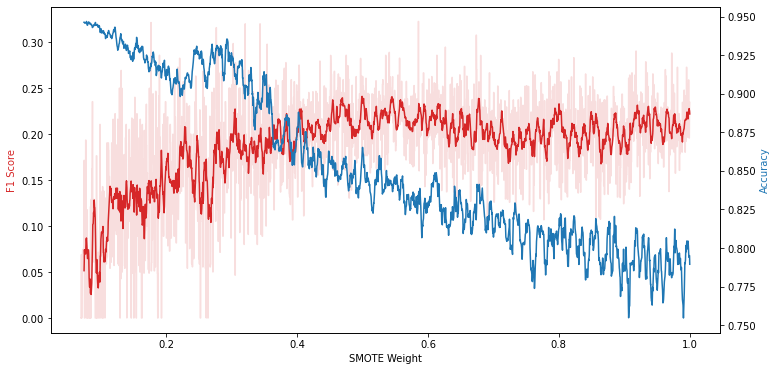

In [16]:
## Plotting moving average of SMOTE weights and scors
for i in range(15,len(results)):
    results_sm['MA_F1'][i] = (results_sm['F1 Score'][i-15:i]).mean()
    results_sm['MA_Acc'][i] = (results_sm['Accuracy'][i-15:i]).mean()

## Plot
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(results_sm['Weight'], results_sm['MA_F1'], color='tab:red', label="F1 Score")
ax.plot(results_sm['Weight'], results_sm['F1 Score'], color='tab:red', label="F1 Score", alpha=0.15)
ax.set_ylabel('F1 Score', color='tab:red')
ax.set_xlabel("SMOTE Weight")
ax2=ax.twinx()
ax2.plot(results_sm['Weight'], results_sm['MA_Acc'], color='tab:blue', label="Accuracy")
ax2.set_ylabel('Accuracy', color='tab:blue')
plt.show();

In [17]:
results_sm.loc[results_sm['MA_F1'].idxmax()]

Weight      0.499493
Accuracy    0.863014
F1 Score    0.166667
MA_Acc      0.860665
MA_F1       0.241061
Name: 1385, dtype: float64

In [18]:
## Run best model on testing data

sm = SMOTE(random_state=12, sampling_strategy=0.5) # 0.3 without Norm
X_train_res, Y_train_res = sm.fit_resample(X_train, Y_train)

model = DecisionTreeClassifier(criterion='gini', 
                                   splitter='best', 
                                   max_depth=7,
                                   min_samples_leaf=3, 
                                   max_features=4, 
                                   random_state=425).fit(X_train_res, Y_train_res)

Y_val_pred = model.predict(X_test)

generate_model_report(Y_test, Y_val_pred)
pd.crosstab(Y_test, Y_val_pred, rownames=['Predicted'], colnames=['Actual'])

Accuracy:  0.8246575342465754
Precision: 0.14253897550111358
Recall:    0.5039370078740157
F1 Score:  0.2222222222222222
AUC Score: 0.6726851431462336


Actual,0.0,1.0
Predicted,,
0.0,2043,385
1.0,63,64


## UNDERSAMPLING

In [19]:
from imblearn.under_sampling import NearMiss

## Initialize dataframe of all parameters to be validated
results = pd.DataFrame(columns = ['Neigbhors', 
                                  'Criterion', 
                                  'Splitter', 
                                  'Depth', 
                                  'Leaf', 
                                  'Feature', 
                                  'Accuracy', 
                                  'F1 Score', 
                                  'AUC Score'])

## Loop over all parameters
for neighbor in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    for crit in ['gini', 'entropy']:
        for split in ['best', 'random']:
            for depth in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
                for leaf in [1, 2, 3, 4, 5]:
                    for feature in [1, 2, 3, 4, 5, 6, 7, 8, 'sqrt', 'log2']:
                        
                        ## Underampling technique
                        nm = NearMiss(version=1,n_neighbors=neighbor)
                        X_train_res, Y_train_res = nm.fit_resample(X_train, Y_train)
                        
                        ## Model definition
                        model = DecisionTreeClassifier(criterion=crit, 
                                                       splitter=split, 
                                                       max_depth=depth, 
                                                       min_samples_leaf=leaf, 
                                                       max_features=feature, 
                                                       random_state=425)
                        ## Model fitting        
                        dct = model.fit(X_train_res, Y_train_res)
                        Y_val_pred = model.predict(X_val) # Predicted values
                        
                        ## Model evaluation
                        accuracy = accuracy_score(Y_val, Y_val_pred)
                        f1 = f1_score(Y_val, Y_val_pred)
                        auc = roc_auc_score(Y_val, Y_val_pred)
                        
                        ## Append results to dataframe
                        results = results.append({'Neigbhors':weight, 
                                                  'Criterion':crit,
                                                  'Splitter': split,
                                                  'Depth': depth,
                                                  'Leaf': leaf,
                                                  'Feature': feature,
                                                  'Accuracy':accuracy,
                                                  'F1 Score':f1,
                                                  'AUC Score': auc}, ignore_index = True)

In [20]:
## Retrieve result with highest F1 Score
results.loc[results['F1 Score'].idxmax()]

Neigbhors           1
Criterion        gini
Splitter         best
Depth               3
Leaf                1
Feature             6
Accuracy     0.831703
F1 Score     0.271186
AUC Score    0.740782
Name: 10105, dtype: object

In [22]:
## Run best model on testing data
nm = NearMiss(version=1, n_neighbors=1)
X_train_res, Y_train_res = nm.fit_resample(X_train, Y_train)

model = DecisionTreeClassifier(criterion='gini', 
                                   splitter='best',  # random without Norm
                                   max_depth=3, #  8 without Norm
                                   min_samples_leaf=1,  # 4 without norm
                                   max_features=6, # 2 without norm
                                   random_state=425).fit(X_train_res, Y_train_res)
Y_val_pred = model.predict(X_test)

generate_model_report(Y_test, Y_val_pred)
pd.crosstab(Y_test, Y_val_pred, rownames=['Predicted'], colnames=['Actual'])

Accuracy:  0.6747553816046967
Precision: 0.1036036036036036
Recall:    0.7244094488188977
F1 Score:  0.1812807881773399
AUC Score: 0.6982838018394324


Actual,0.0,1.0
Predicted,,
0.0,1632,796
1.0,35,92


# RANDOM FOREST

## BASELINE

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
#from sklearn.ensemble import AdaBoostClassifier

rforest = RandomForestClassifier(n_estimators = 20, random_state=425)
rforest.fit(X_train, Y_train)

# Predicted values
Y_test_pred = rforest.predict(X_test) 
                        
## Model evaluation
generate_model_report(Y_test, Y_test_pred)
pd.crosstab(Y_test, Y_test_pred, rownames=['Predicted'], colnames=['Actual'])

RandomForestClassifier(n_estimators=20, random_state=425)

Accuracy:  0.9471624266144814
Precision: 0.21428571428571427
Recall:    0.023622047244094488
F1 Score:  0.04255319148936171
AUC Score: 0.5095457847423108


Actual,0.0,1.0
Predicted,,
0.0,2417,11
1.0,124,3


## OVERSAMPLING

In [83]:
from imblearn.over_sampling import SMOTE

## Initialize dataframe of all parameters to be validated
results = pd.DataFrame(columns = ['Weight', 
                                  'N Estimator',
                                  'Criterion', 
                                  'Depth', 
                                  'Leaf', 
                                  'Feature', 
                                  'Accuracy', 
                                  'F1 Score', 
                                  'AUC Score'])

## Loop over all parameters
for weight in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]: # SMOTE Ratio
    for nest in [3,5,7,15]:
        for crit in ['gini', 'entropy']:
            for depth in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
                for leaf in [1, 2, 3, 4, 5]:
                    for feature in [1, 2, 3, 4, 5, 6, 7, 8, 'sqrt', 'log2']:
                            
                            ## Oversampling technique
                            sm = SMOTE(random_state=12, sampling_strategy=weight)
                            X_train_res, Y_train_res = sm.fit_resample(X_train, Y_train)
                        
                            ## Model definition
                            model = RandomForestClassifier(n_estimators=nest,
                                                           criterion=crit, 
                                                           max_depth=depth, 
                                                           min_samples_leaf=leaf, 
                                                           max_features=feature,
                                                           #bootstrap=True,
                                                           #class_weight = 'balanced_subsample',
                                                           random_state=425)
                        
                            ## Model fitting
                            dct = model.fit(X_train_res, Y_train_res)
                            Y_val_pred = model.predict(X_val) # predicted values
                            
                            ## Model evaluation
                            accuracy = accuracy_score(Y_val, Y_val_pred)
                            f1 = f1_score(Y_val, Y_val_pred)
                            auc = roc_auc_score(Y_val, Y_val_pred)
                        
                            ## Append results to dataframe
                            results = results.append({'Weight':weight,
                                                      'N Estimator':nest,
                                                      'Criterion':crit,
                                                      'Depth': depth,
                                                      'Leaf': leaf,
                                                      'Feature': feature,
                                                      'Accuracy':accuracy,
                                                      'F1 Score':f1,
                                                      'AUC Score': auc}, ignore_index = True)

In [84]:
results.loc[results['F1 Score'].idxmax()]

Weight              0.5
N Estimator           7
Criterion       entropy
Depth                 5
Leaf                  1
Feature               4
Accuracy       0.947162
F1 Score        0.44898
AUC Score      0.706626
Name: 18703, dtype: object

In [85]:
## Another loop to get more granularity of SMOTE
# Before I tested 10 different smote weights, now I test 3000
results_sm = pd.DataFrame(columns = ['Weight', 'Accuracy', 'F1 Score', 'MA_Acc', 'MA_F1'])
weights = np.linspace(0.07, 1, 3000)

for weight in weights:
    sm = SMOTE(random_state=12, sampling_strategy=weight)
    X_train_res, Y_train_res = sm.fit_resample(X_train, Y_train)
    model = RandomForestClassifier(criterion='entropy', 
                                   n_estimators=7,
                                   max_depth=5,
                                   min_samples_leaf=1, # 5 with norm
                                   max_features=4,  # 1 with norm
                                   random_state=425).fit(X_train_res, Y_train_res)
    Y_val_pred = model.predict(X_val)
    accuracy = accuracy_score(Y_val, Y_val_pred)
    f1 = f1_score(Y_val, Y_val_pred)
    results_sm = results_sm.append({'Weight':weight, 'Accuracy':accuracy,'F1 Score':f1}, ignore_index = True)

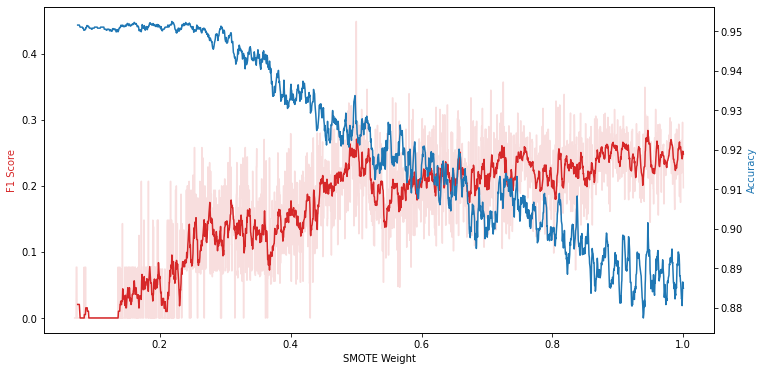

In [86]:
## Plotting moving average of SMOTE weights and scors
for i in range(15,len(results)):
    results_sm['MA_F1'][i] = (results_sm['F1 Score'][i-15:i]).mean()
    results_sm['MA_Acc'][i] = (results_sm['Accuracy'][i-15:i]).mean()

## Plot
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(results_sm['Weight'], results_sm['MA_F1'], color='tab:red', label="F1 Score")
ax.plot(results_sm['Weight'], results_sm['F1 Score'], color='tab:red', label="F1 Score", alpha=0.15)
ax.set_ylabel('F1 Score', color='tab:red')
ax.set_xlabel("SMOTE Weight")
ax2=ax.twinx()
ax2.plot(results_sm['Weight'], results_sm['MA_Acc'], color='tab:blue', label="Accuracy")
ax2.set_ylabel('Accuracy', color='tab:blue')
plt.show();

In [87]:
results_sm.loc[results_sm['F1 Score'].idxmax()]

Weight      0.500113
Accuracy    0.947162
F1 Score    0.448980
MA_Acc      0.926549
MA_F1       0.244232
Name: 1387, dtype: float64

In [92]:
## Run best model on testing data
sm = SMOTE(random_state=12, sampling_strategy=0.5)
X_train_res, Y_train_res = sm.fit_resample(X_train, Y_train)

model = RandomForestClassifier(criterion='entropy', 
                                   n_estimators=7, 
                                   max_depth=5,
                                   min_samples_leaf=1, 
                                   max_features=4, 
                                   random_state=425).fit(X_train_res, Y_train_res)

Y_test_pred = model.predict(X_test)

generate_model_report(Y_test, Y_test_pred)
pd.crosstab(Y_test, Y_test_pred, rownames=['Predicted'], colnames=['Actual'])

Accuracy:  0.910371819960861
Precision: 0.16883116883116883
Recall:    0.2047244094488189
F1 Score:  0.18505338078291814
AUC Score: 0.5760030613965677


Actual,0.0,1.0
Predicted,,
0.0,2300,128
1.0,101,26


## UNDERSAMPLING

In [93]:
from imblearn.under_sampling import NearMiss

## Initialize dataframe of all parameters to be validated
results = pd.DataFrame(columns = ['Neigbhors', 
                                  'Criterion', 
                                  'Splitter', 
                                  'Depth', 
                                  'Leaf', 
                                  'Feature', 
                                  'Accuracy', 
                                  'F1 Score', 
                                  'AUC Score'])

## Loop over all parameters
for neighbor in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    for nest in [3,5,7,15]:
        for crit in ['gini', 'entropy']:
            for depth in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
                for leaf in [1, 2, 3, 4, 5]:
                    for feature in [1, 2, 3, 4, 5, 6, 7, 8, 'sqrt', 'log2']:
                        
                        ## Underampling technique
                        nm = NearMiss(version=1,n_neighbors=neighbor)
                        X_train_res, Y_train_res = nm.fit_resample(X_train, Y_train)
                        
                        ## Model definition
                        model = RandomForestClassifier(n_estimators=nest,
                                                       criterion=crit, 
                                                       max_depth=depth, 
                                                       min_samples_leaf=leaf, 
                                                       max_features=feature, 
                                                       random_state=425)
                        ## Model fitting        
                        dct = model.fit(X_train_res, Y_train_res)
                        Y_val_pred = model.predict(X_val) # Predicted values
                        
                        ## Model evaluation
                        accuracy = accuracy_score(Y_val, Y_val_pred)
                        f1 = f1_score(Y_val, Y_val_pred)
                        auc = roc_auc_score(Y_val, Y_val_pred)
                        
                        ## Append results to dataframe
                        results = results.append({'Neigbhors':weight, 
                                                  'Criterion':crit,
                                                  'Splitter': sp,
                                                  'Depth': depth,
                                                  'Leaf': leaf,
                                                  'Feature': feature,
                                                  'Accuracy':accuracy,
                                                  'F1 Score':f1,
                                                  'AUC Score': auc}, ignore_index = True)

In [94]:
results.loc[results['F1 Score'].idxmax()]

Neigbhors           1
Criterion        gini
Splitter       random
Depth               8
Leaf                2
Feature             2
Accuracy     0.763209
F1 Score     0.238994
AUC Score    0.761687
Name: 2361, dtype: object

In [96]:
## Run best model on testing data
nm = NearMiss(version=1, n_neighbors=1)
X_train_res, Y_train_res = nm.fit_resample(X_train, Y_train)

model = DecisionTreeClassifier(criterion='gini', 
                                   splitter='random', 
                                   max_depth=8, # 1 with norm
                                   min_samples_leaf=2,  # 1 with norm
                                   max_features=2, # 5 with norm
                                   random_state=425).fit(X_train_res, Y_train_res)
Y_val_pred = model.predict(X_test)

generate_model_report(Y_test, Y_val_pred)
pd.crosstab(Y_test, Y_val_pred, rownames=['Predicted'], colnames=['Actual'])

Accuracy:  0.7068493150684931
Precision: 0.06805555555555555
Recall:    0.3858267716535433
F1 Score:  0.11570247933884296
AUC Score: 0.5547338141628507


Actual,0.0,1.0
Predicted,,
0.0,1757,671
1.0,78,49
